In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
# Chargement
df = pd.read_csv(r"C:\Users\Ph\Downloads\dataset_entretien_ml_regression.csv")

# Suppression des doublons
df = df.drop_duplicates()

# Séparation types
numeric_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include='object').columns

# Imputation
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                300 non-null    float64
 1   revenu_mensuel     300 non-null    float64
 2   anciennete_annees  300 non-null    int64  
 3   type_contrat       300 non-null    object 
 4   secteur            300 non-null    object 
 5   region             300 non-null    object 
 6   depense_annuelle   300 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 18.8+ KB


,age,revenu_mensuel,anciennete_annees,type_contrat,secteur,region,depense_annuelle
0,56.000000,249811.793478,17,CDI,Education,Dakar,1329964.0
1,46.000000,219334.000000,9,CDI,Education,Thiès,1140748.0
2,41.018116,212998.000000,5,CDI,Commerce,Dakar,913219.0
3,60.000000,161000.000000,0,CDD,Commerce,Dakar,1191590.0
4,41.018116,319378.000000,4,CDI,IT,Dakar,1975220.0


In [4]:
# Standardisation
X = df[numeric_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
# pca compléte(sans fixer n_components)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


     Variance expliquée  Variance cumulée
PC1            0.455434          0.455434
PC2            0.268772          0.724206
PC3            0.235107          0.959313
PC4            0.040687          1.000000


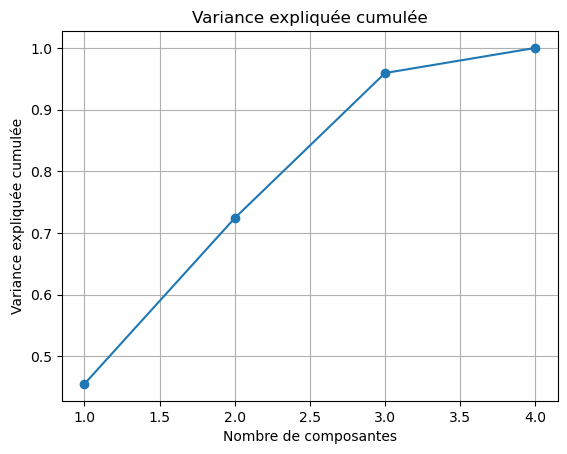

In [6]:
# Variance expliquée et variance cumulée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

variance_df = pd.DataFrame({
    'Variance expliquée': explained_variance,
    'Variance cumulée': cumulative_variance
}, index=[f'PC{i+1}' for i in range(len(explained_variance))])

print(variance_df)

plt.plot(range(1, len(cumulative_variance)+1),
         cumulative_variance, marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée cumulée")
plt.grid()
plt.show()


In [7]:
# Valeurs propres
eigenvalues = pca.explained_variance_

eigen_df = pd.DataFrame({
    'Valeur propre': eigenvalues
}, index=[f'PC{i+1}' for i in range(len(eigenvalues))])

print(eigen_df)


     Valeur propre
PC1       1.827829
PC2       1.078683
PC3       0.943572
PC4       0.163294


In [8]:
# Choix du plan factoriel
pca = PCA(n_components=2)
X_pca_2 = pca.fit_transform(X_scaled)

eigenvalues = pca.explained_variance_


In [9]:
# Coordonnées des variables dans le plan factoriel
coord_var = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=numeric_cols
)

print(coord_var)


                        PC1       PC2
age                0.063967 -0.646381
revenu_mensuel     0.694411 -0.118829
anciennete_annees  0.105979  0.751114
depense_annuelle   0.708851  0.062439


In [10]:
# Corrélations des variables et des axes factoriels
corr_var = coord_var.copy()

for i, axis in enumerate(['PC1', 'PC2']):
    corr_var[axis] = coord_var[axis] * np.sqrt(eigenvalues[i])

print(corr_var)


                        PC1       PC2
age                0.086481 -0.671329
revenu_mensuel     0.938824 -0.123415
anciennete_annees  0.143281  0.780105
depense_annuelle   0.958347  0.064849


In [11]:
# Qualité de projection des variables(cos2)
cos2_var = corr_var**2

print(cos2_var)


                        PC1       PC2
age                0.007479  0.450683
revenu_mensuel     0.881391  0.015231
anciennete_annees  0.020530  0.608564
depense_annuelle   0.918430  0.004205


In [12]:
# Contribution des variables aux axes
contrib_var = (corr_var**2) / eigenvalues * 100

print(contrib_var)


                         PC1        PC2
age                 0.409175  41.780828
revenu_mensuel     48.220626   1.412024
anciennete_annees   1.123165  56.417284
depense_annuelle   50.247034   0.389864


In [13]:
# Coordonnées des individus dans le plan factoriel
coord_individus = pd.DataFrame(
    X_pca_2,
    columns=['PC1', 'PC2'],
    index=df.index
)

print(coord_individus.head())


        PC1       PC2
0 -0.022032  0.291623
1 -0.728315 -0.247363
2 -1.183498 -0.546098
3 -1.248650 -2.052518
4  1.101386 -0.706916


In [14]:
# Qualité de représentation des individus(cos2)
squared_dist = np.sum(coord_individus**2, axis=1)

cos2_individus = coord_individus.copy()

for axis in ['PC1', 'PC2']:
    cos2_individus[axis] = (
        coord_individus[axis]**2 / squared_dist
    )

print(cos2_individus.head())


        PC1       PC2
0  0.005676  0.994324
1  0.896577  0.103423
2  0.824460  0.175540
3  0.270121  0.729879
4  0.708235  0.291765


In [15]:
# Contribution des individus aux axes factoriels
n = coord_individus.shape[0]

contrib_individus = pd.DataFrame(index=df.index)

for i, axis in enumerate(['PC1', 'PC2']):
    contrib_individus[axis] = (
        coord_individus[axis]**2
    ) / (n * eigenvalues[i]) * 100

print(contrib_individus.head())


        PC1       PC2
0  0.000089  0.026280
1  0.096735  0.018908
2  0.255434  0.092157
3  0.284331  1.301844
4  0.221219  0.154426


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


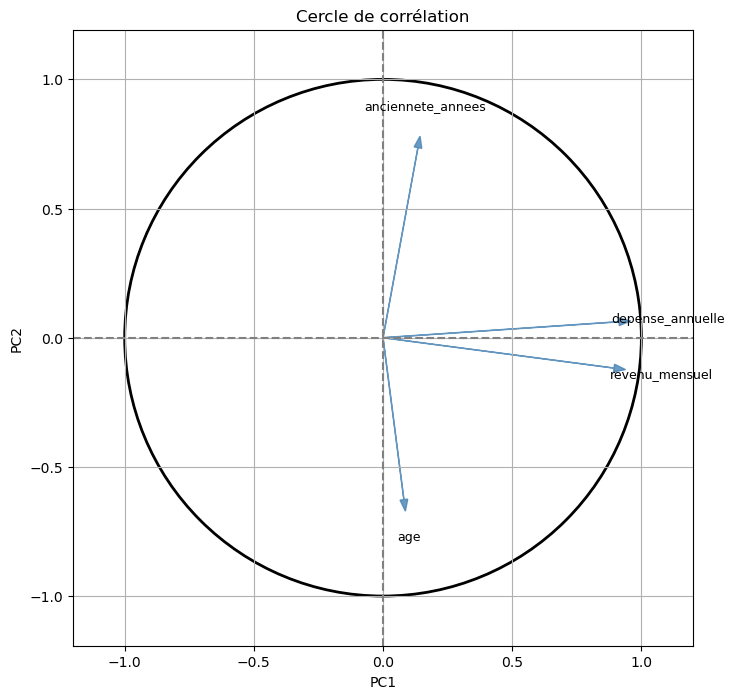

In [23]:
# Cercle de corrélation

plt.figure(figsize=(8, 8))

# Cercle unité
circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2)
plt.gca().add_artist(circle)

# Flèches et labels des variables
for var in corr_var.index:
    x = corr_var.loc[var, 'PC1']
    y = corr_var.loc[var, 'PC2']
    
    plt.arrow(0, 0, x, y, color='steelblue', alpha=0.8,
              head_width=0.03, length_includes_head=True)
    plt.text(x*1.15, y*1.15, var, fontsize=9, ha='center', va='center')

# Axes
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')

# Cercle parfait + marges pour flèches
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle de corrélation')
plt.grid(True)
plt.show()


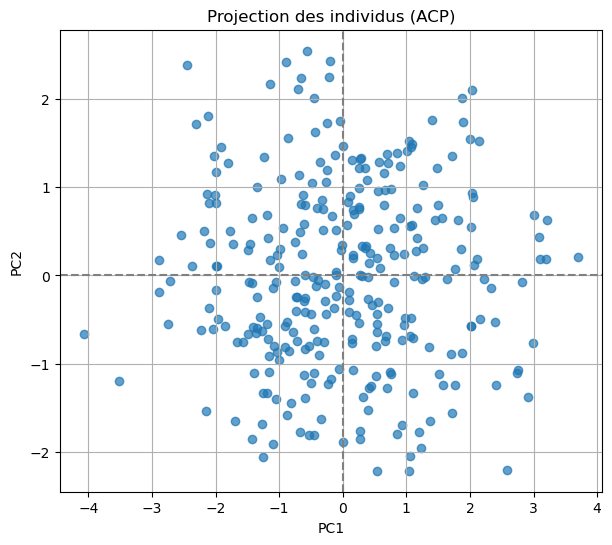

In [20]:
# Projection des individus dans le plan factoriel
plt.figure(figsize=(7,6))
plt.scatter(coord_individus['PC1'],
            coord_individus['PC2'],
            alpha=0.7)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection des individus (ACP)')
plt.grid()
plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


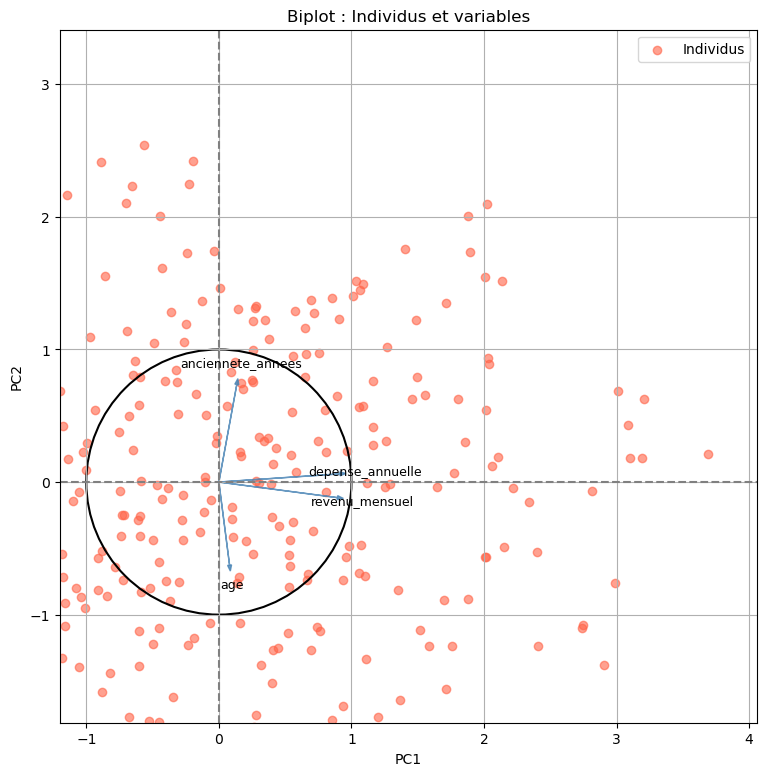

In [24]:
# Biplot individus variables
plt.figure(figsize=(9, 9))

# --- Projection des individus ---
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], alpha=0.6, color='tomato', label='Individus')

# --- Flèches des variables ---
for var in corr_var.index:
    x = corr_var.loc[var, 'PC1']
    y = corr_var.loc[var, 'PC2']
    plt.arrow(0, 0, x, y, color='steelblue', alpha=0.8,
              head_width=0.03, length_includes_head=True)
    plt.text(x*1.15, y*1.15, var, fontsize=9, ha='center', va='center')

# --- Cercle unité (pour les variables) ---
circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=1.5)
plt.gca().add_artist(circle)

# Axes
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')

# Ratio égal pour le cercle
plt.axis('equal')
plt.xlim(-1.2, max(1.2, X_pca_2[:,0].max()*1.1))
plt.ylim(-1.2, max(1.2, X_pca_2[:,1].max()*1.1))

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot : Individus et variables')
plt.grid(True)
plt.legend()
plt.show()
